In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


# Requirements

In [2]:
!pip3 install jupyter==1.0.0
!pip3 install numpy==1.23.1
!pip3 install pandas==1.4.3
!pip3 install pytorch-lightning==1.7.0
!pip3 install scikit-learn==1.1.1
!pip3 install scipy==1.8.1
!pip3 install seaborn==0.11.2
!pip3 install sklearn==0.0
!pip3 install tensorboard==2.9.1
!pip3 install tqdm==4.64.0
!pip3 install torchinfo==1.7.0
!pip3 install opencv-opencv-contrib-python==4.6.0.6
!pip3 install scikit_image=0.19.3
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

# Import statements

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchinfo import summary
import cv2

In [2]:
%matplotlib inline

# Configuration

In [3]:
config = dict(
    # Path directory for dataset
    dataset_path="datasets/pokemon/sprites/pokemon/other/official-artwork",
    # Path fo model checkpoint
    checkpoint_path=".pytorch/pokemon_dcgan/",
    # Number of workers for dataloader
    num_workers=8,
    # Batch size during training
    batch_size=128,
    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
    image_size=64,
    # Number of channels in the training images. For color images this is 3
    num_channel=3,
    # Size of z latent vector (i.e. size of generator input)
    z_size=100,
    # Size of feature maps in generator
    generator_hidden_size=64,
    # Generator network dimentions
    gen_dims = [8, 4, 2, 1],
    # Size of feature maps in discriminator
    discriminator_hidden_size=64,
    # Number of training epochs
    num_epochs=5,
    # Learning rate for optimizers
    lr=0.0002,
    # Beta1 hyperparam for Adam optimizers
    beta1=0.5,
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu=1,
)

device = torch.device("cuda:0" if (torch.cuda.is_available() and config['ngpu'] > 0 ) else "cpu")


# Prepare Dataset

In [4]:
!git clone https://github.com/PokeAPI/sprites.git datasets/pokemon/
!mkdir -p {config['dataset_path']}/0
!mv {config['dataset_path']}/*.png {config['dataset_path']}/0/


fatal: destination path 'datasets/pokemon' already exists and is not an empty directory.
mv: cannot stat 'datasets/pokemon/sprites/pokemon/other/official-artwork/*.png': No such file or directory


In [5]:
# New Dataset instance based on official artwork
def transparent_white_bg_loader(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    alpha_channel = img[:, :, 3]
    _, mask = cv2.threshold(alpha_channel, 254, 255, cv2.THRESH_BINARY)  # binarize mask
    color = img[:, :, :3]
    new_img = cv2.bitwise_not(cv2.bitwise_not(color, mask=mask))
    return new_img
dataset = dset.ImageFolder(
    root=config['dataset_path'],
    loader = transparent_white_bg_loader,
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(config['image_size']),
        transforms.CenterCrop(config['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        ),
    ])
)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers']
)

## Visualize Dataset

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

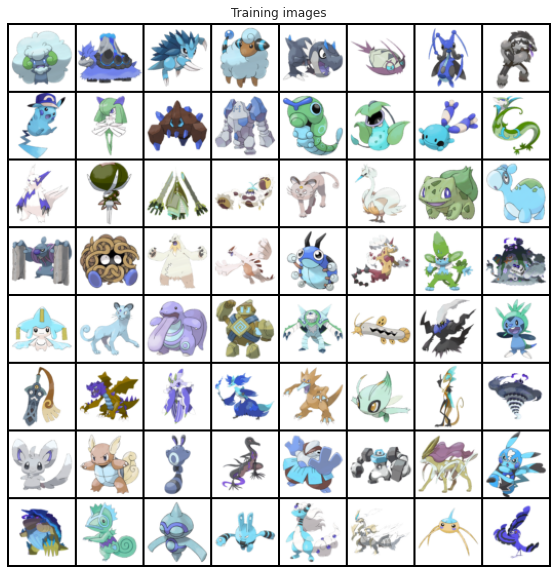

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).permute([1, 2, 0]).cpu()
)
plt.show()

# Model

## Helper functions

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Network

In [8]:

class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, num_channel, gen_dims, negative_slope=0.2, kernel_size=4):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_channel = num_channel
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.features = self._make_layers(gen_dims, negative_slope)

    def _make_layers(self, gen_dims, negative_slope):
        layers = []
        in_channels = self.input_size
        for i, layer in enumerate(gen_dims):
            layers += [
                nn.ConvTranspose2d(
                    in_channels,
                    self.hidden_dim*layer,
                    self.kernel_size,
                    bias=False,
                    stride=1 if i == 0 else 2,
                    padding=0 if i == 0 else 1,
                ),
                nn.BatchNorm2d(self.hidden_dim*layer),
                nn.LeakyReLU(negative_slope=negative_slope),
            ]
            in_channels = self.hidden_dim*layer
        layers += [
            nn.ConvTranspose2d(
                in_channels,
                self.num_channel,
                self.kernel_size,
                bias=False,
                stride=2,
                padding=1,
            ),
            nn.Tanh()
        ]
        return nn.Sequential(*layers)
    
    def forward(self, input):
        return self.features(input)


In [9]:
# Instantiate the generator
G = Generator(
    config['z_size'],
    config['generator_hidden_size'],
    config['num_channel'],
    config['gen_dims'],
).to(device)

# Random weights initialization
#  to mean=0, stdev=0.02
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (features): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), pad

In [16]:
summary(G, (1, config['z_size'], 1, 1), col_names=["input_size", "output_size", "kernel_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Generator                                [1, 100, 1, 1]            [1, 3, 64, 64]            4                         --
├─Sequential: 1-1                        [1, 100, 1, 1]            [1, 3, 64, 64]            --                        --
│    └─ConvTranspose2d: 2-1              [1, 100, 1, 1]            [1, 512, 4, 4]            [4, 4]                    819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            [1, 512, 4, 4]            --                        1,024
│    └─LeakyReLU: 2-3                    [1, 512, 4, 4]            [1, 512, 4, 4]            --                        --
│    └─ConvTranspose2d: 2-4              [1, 512, 4, 4]            [1, 256, 8, 8]            [4, 4]                    2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            [1, 256, 8, 8]            --                        512
│  